In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp learner

In [ ]:
from fastcore.test import *

In [ ]:
#| export
import torch
from torch import Tensor
from torch.distributions import MultivariateNormal 

import gpytorch
from gpfa_imputation.gpfa import *
from collections import namedtuple
import math

from fastcore.foundation import *
from fastprogress.fastprogress import progress_bar, master_bar
from fastcore.foundation import patch

The first thing that we need is a Learner object to keep track of:

- input data, output data
- model
- likelihood

and that has methods to help with:

- training
- prediction 
- visualization

The first thing we need is a training loop, just wrap in a function the example one from GPyTorch


### Normalization

The different variables in the can have pretty different values so we normalize so they are more comparable. Have numbers between 0 and 1 should also help with the computation accuracy.

One additional complexity is the need to backtransform not only the mean but also the standard deviation.

So we need a but of math

$$x_{norm} = \frac{x - \mu_x}{\sigma_x}$$
then
$$x = x_{norm}\sigma_x + \mu_x $$

using properties of Guassian distributions ^[https://cs.nyu.edu/~roweis/notes/gaussid.pdf eq. 4a]

$$p(x_{norm}) = \mathcal{N}(\mu_{norm}, \sigma^2_{norm})$$

$$p(x) = \mathcal{N}(\sigma_x\mu_{norm} + \mu_x, \sigma^2_x \sigma^2_{norm})$$

In [ ]:
#| export
class Normalizer:
    def __init__(self,
                 x: Tensor # up to 2D Tensor
                ):
        """Init normalizer by storing mean and std dev"""
        self.x_mean = x.mean(axis=0)
        self.x_std = x.std(axis=0)
        
    def normalize(self,
        x: Tensor # up to 2D tensor 
                 ) -> Tensor: # x_normalized
        "Normalize (substract mean and divide by standard deviation) input tensor"
        x_mean = x.mean(axis=0)
        x_std = x.std(axis=0)

        return ((x - self.x_mean) / self.x_std)

    def reverse_normalize(self,
        x_norm, # Normalized array
                          ) -> Tensor:       # Array after reversing normalization
        return x_norm * self.x_std + self.x_mean

    def reverse_normalize_std(self,
        x_std_norm, # Normalized array of standard deviations
                          ) -> Tensor:       # Array after reversing normalization
        return x_std_norm * self.x_std

In [ ]:
x = torch.randn(20).reshape(-1,2)
norm = Normalizer(x)
test_close(x, norm.reverse_normalize(norm.normalize(x)))
test_close(x.std(axis=0), norm.reverse_normalize_std(norm.normalize(x).std(axis=0)))

## Learner

In [ ]:
#| export
class GPFALearner():
    def __init__(self,
                 X: Tensor, # (n_features * n_obs) Multivariate time series
                 T: Tensor = None # (n_obs) Vector of time of observations.
                 # If none each observation is considered to be at the same distance
                ):
        self.prepare_X(X)
        if T is None: self.default_time(X)
        else: self.T = T
        
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        latent_kernel = gpytorch.kernels.RBFKernel()
        self.model = GPFA(self.T, self.X, self.likelihood, self.n_features, latent_kernel)
        
    @torch.no_grad()
    def prepare_X(self, X):
        self.norm = Normalizer(X)
        X = self.norm.normalize(X)
        # flatten Matrix to vector
        self.X = X.reshape(-1) 
        self.n_features = X.shape[1]
        
    @torch.no_grad()
    def default_time(self, X):
        self.T = torch.arange(X.shape[0])
        
    
    def train(self, n_iter=100, lr=0.1):
        # need to enable training mode
        self.model.train()
        self.likelihood.train()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) 
        
        self.losses = torch.zeros(n_iter)
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
        self.pb = master_bar([1])
        for _ in self.pb:
            for i in progress_bar(range(n_iter), parent=self.pb):
                # Zero gradients from previous iteration
                optimizer.zero_grad()
                # Output from model
                output = self.model(self.T)
                # Calc loss and backprop gradients
                loss = -mll(output, self.X)
                self.losses[i] = loss.detach()
                loss.backward()
                self.printer(i)

                optimizer.step()
        
        
    def printer(self, i):
        pass
        

In [ ]:
# test data
T = torch.arange(0,6)

X = torch.vstack([(torch.arange(0,3, dtype=torch.float32) + 2 + i) * i for i in T]) 

In [ ]:
X

tensor([[ 0.,  0.,  0.],
        [ 3.,  4.,  5.],
        [ 8., 10., 12.],
        [15., 18., 21.],
        [24., 28., 32.],
        [35., 40., 45.]])

In [ ]:
# l for learner
l = GPFALearner(X)

In [ ]:
test_eq(T, l.T)

In [ ]:
# with explicit time
test_eq(T, GPFALearner(X, T).T)

In [ ]:
test_eq(l.n_features, 3)

In [ ]:
l.X

tensor([-1.0590, -1.0955, -1.1236, -0.8347, -0.8326, -0.8305, -0.4610, -0.4382,
        -0.4201,  0.0623,  0.0876,  0.1075,  0.7350,  0.7449,  0.7523,  1.5573,
         1.5337,  1.5145])

In [ ]:
l.train()

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

In [ ]:
l.losses

tensor([ 1.3442,  1.3034,  1.2644,  1.2289,  1.1978,  1.1685,  1.1362,  1.1000,
         1.0615,  1.0225,  0.9837,  0.9453,  0.9072,  0.8689,  0.8301,  0.7906,
         0.7506,  0.7100,  0.6689,  0.6275,  0.5859,  0.5442,  0.5025,  0.4608,
         0.4190,  0.3772,  0.3353,  0.2932,  0.2510,  0.2086,  0.1662,  0.1237,
         0.0813,  0.0389, -0.0033, -0.0455, -0.0876, -0.1296, -0.1714, -0.2132,
        -0.2548, -0.2962, -0.3375, -0.3786, -0.4196, -0.4603, -0.5008, -0.5410,
        -0.5810, -0.6207, -0.6601, -0.6990, -0.7343, -0.7640, -0.8089, -0.8364,
        -0.8857, -0.9075, -0.9574, -0.9789, -1.0242, -1.0492, -1.0886, -1.1164,
        -1.1515, -1.1772, -1.2128, -1.2350, -1.2700, -1.2861, -1.3172, -1.3314,
        -1.3617, -1.3904, -1.4003, -1.4268, -1.4382, -1.4574, -1.4849, -1.4873,
        -1.5002, -1.5141, -1.5112, -1.5356, -1.5542, -1.5486, -1.5625, -1.5695,
        -1.5620, -1.5779, -1.5880, -1.5860, -1.6030, -1.6040, -1.5996, -1.6096,
        -1.6022, -1.5983, -1.6107, -1.61

## Predictions

add a function to get predictions from the model

In [ ]:
#| export
@torch.no_grad() # don't calc gradients on predictions
@patch()
def predict_raw(self: GPFALearner, T):
    self.model.eval()
    self.likelihood.eval()
    return self.likelihood(self.model(T))

In [ ]:
raw_out = l.predict_raw(T)
raw_out

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


MultivariateNormal(loc: torch.Size([18]))

the model prediction is a distribution with `len(T)*n_features` dimensions

which is in the in the wrong shape and need to be rescaled after the normalization

Also we don't need th full distribution but only the mean and stddev for each variable at every time step

And we can "fix" the shape by transforming back to a matrix

In [ ]:
raw_stddev = raw_out.stddev.reshape(-1, l.n_features)
raw_mean = raw_out.mean.reshape(-1, l.n_features)

In [ ]:
raw_stddev

tensor([[0.0250, 0.0198, 0.0224],
        [0.0242, 0.0187, 0.0214],
        [0.0239, 0.0183, 0.0211],
        [0.0239, 0.0183, 0.0211],
        [0.0242, 0.0187, 0.0214],
        [0.0250, 0.0198, 0.0224]], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
#| export
NormParam = namedtuple("NormalParameters", ["mean", "std"])

This function transforms the raw output of the Gaussian Process (`p(X)`) into a prediction that can be used.
need to do two things:

- take mean and stddev (this is the diagonal of the covariance matrix) for each variable
- reshape so that each row is a time step and each column a variable
- reverse the normalization

the mean and the std are passed individually because in the conditional predictions is not possible to have the whole covariance matrix (and thus a MultiNormal) but the mean and stddev are enough.

In [ ]:
#|export
@torch.no_grad() # needed because raw output still has gradients attached
@patch
def prediction_from_raw(self: GPFALearner, raw_mean, raw_std):
    """ Takes a raw prediction and produces and final prediction, by reshaping and reversing normalization"""
    raw_std = raw_std.reshape(-1, self.n_features)
    raw_mean = raw_mean.reshape(-1, self.n_features)
    
    pred_mean = self.norm.reverse_normalize(raw_mean)
    pred_std = self.norm.reverse_normalize_std(raw_std)
    
    #remove pytorch gradients
    return NormParam(pred_mean.detach(), pred_std.detach())

In [ ]:
# TODO document this function better

In [ ]:
@patch
def predict(self: GPFALearner, T):
    pred_raw = self.predict_raw(T)
    return self.prediction_from_raw(pred_raw.mean, pred_raw.stddev)

In [ ]:
l.predict(T)

NormalParameters(mean=tensor([[-4.5984e-01, -1.7553e-02,  4.4573e-01],
        [ 3.0967e+00,  4.0383e+00,  4.9975e+00],
        [ 8.2710e+00,  9.9444e+00,  1.1622e+01],
        [ 1.5309e+01,  1.7973e+01,  2.0630e+01],
        [ 2.4203e+01,  2.8114e+01,  3.2012e+01],
        [ 3.4577e+01,  3.9946e+01,  4.5289e+01]]), std=tensor([[0.3351, 0.3012, 0.3816],
        [0.3239, 0.2848, 0.3657],
        [0.3200, 0.2785, 0.3599],
        [0.3198, 0.2787, 0.3599],
        [0.3239, 0.2848, 0.3659],
        [0.3351, 0.3015, 0.3822]]))

In [ ]:
pred = l.predict(T)

In [ ]:
pred.mean.shape

torch.Size([6, 3])

In [ ]:
pred.std.shape

torch.Size([6, 3])

### Check learning is working

The idea is to use the current model to generate a dataset, that can be for sure modelled using a GPFA (because is the output of GPFA) and then train another model and see if the parameters converge

In [ ]:
# create a dummy GPFA with 3 features
Lt = GPFALearner(X)

In [ ]:
test_params = {
   "Lambda": torch.tensor([-1, 0.3, .8]).reshape(Lt.n_features, -1),
   "psi": torch.tensor([1e-5, 5e-5, 2e-5]),
   "latent_kernel.lengthscale": torch.tensor(5),
}

In [ ]:
Lt.model.covar_module.initialize(**test_params)

GPFAKernel(
  (latent_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_psi_diag_constraint): Positive()
)

In [ ]:
target_X = Lt.predict(T).mean

In [ ]:
l2 = GPFALearner(target_X)

In [ ]:
l2.train()

In [ ]:
l2.predict(T).mean - target_X

tensor([[-4.0693e-03, -8.3923e-04, -8.5640e-04],
        [-2.9421e-03, -3.9482e-04, -1.4305e-04],
        [-9.4700e-04, -1.2779e-04, -4.9591e-05],
        [ 1.1806e-03,  1.1635e-04, -3.4332e-05],
        [ 2.8696e-03,  4.3678e-04,  2.6131e-04],
        [ 3.9005e-03,  8.0872e-04,  8.1444e-04]])

they seems pretty small numbers, so the model is working! 

In [ ]:
print("Lambda:\n", l2.model.covar_module.Lambda.detach())

print("psi: ", l2.model.covar_module.psi.detach())

print("lengthscale:", l2.model.covar_module.latent_kernel.lengthscale.item())

Lambda:
 tensor([[-1.6049],
        [ 1.6213],
        [ 1.6172]])
psi:  tensor([1.0492e-04, 3.8727e-05, 3.8805e-05])
lengthscale: 5.523871421813965


### Conditional Predictions

This add the supports for conditional predictions, which means that at the time (t) when we are making the predictions some of the variables have been actually observed. Since the model prediction is a normal distribution we can condition on the observed values and thus improve the predictions.

Therefore we need to compute the conditional distribution of a normal ^[https://cs.nyu.edu/~roweis/notes/gaussid.pdf eq, 5a, 5d]

$$ X = \left[\begin{array}{c} x \\ o \end{array} \right] $$

$$ p(X) = N\left(\left[ \begin{array}{c} \mu_x \\ \mu_o \end{array} \right], \left[\begin{array}{cc} \Sigma_{xx} & \Sigma_{xo} \\ \Sigma_{ox} & \Sigma_{oo} \end{array} \right]\right)$$

where $X$ is a vector of variable that need to predicted and $o$ is a vector of the variables that have been observed

The mean is in "flat format", where all the features from one time step are next to each other followed by the features of the next time step.

then 

$$p(x|o) = N(\mu_x + \Sigma_{xo}\Sigma_{oo}^{-1}(o - \mu_o), \Sigma_{xx} - \Sigma_{xo}\Sigma_{oo}^{-1}\Sigma_{ox})$$

In [ ]:
#|exporti
def conditional_guassian(gauss: MultivariateNormal,
                         obs,
                         idx # Boolean tensor specifying for each variable is observed (True) or not (False)
                        ):
    μ = gauss.mean
    Σ = gauss.covariance_matrix
    # check idx same size of mu
    μ_x = μ[~idx]
    μ_o = μ[idx]
    
    Σ_xx = Σ[~idx,:][:, ~idx]
    Σ_xo = Σ[~idx,:][:, idx]
    Σ_ox = Σ[idx,:][:, ~idx]
    Σ_oo = Σ[idx,:][:, idx]
    
    Σ_oo_inv = torch.linalg.inv(Σ_oo)
    
    mean = μ_x + Σ_xo@Σ_oo_inv@(obs - μ_o)
    cov = Σ_xx - Σ_xo@Σ_oo_inv@Σ_ox
    
    return MultivariateNormal(mean, cov)
    

In [ ]:
# example distribution with only 2 variables
μ = torch.tensor([.5, 1.])
Σ = torch.tensor([[1., .5], [.5 ,1.]])

gauss = MultivariateNormal(μ, Σ)

idx = torch.tensor([True, False]) # second variable is the observed one

obs = torch.tensor(5.) # value of second variable

gauss_cond = conditional_guassian(gauss, obs, idx)

# hardcoded values to test that the code is working, see also for alternative implementation https://python.quantecon.org/multivariate_normal.html
test_close(3.25, gauss_cond.mean.item())
test_close(.75, gauss_cond.covariance_matrix.item())

Test with multiple variables?

overwrite the predict method to add support for conditional predictions

Need to have the mean and std for both the conditional predictions and the observations, with the same shape and order of the complete prediction. 

In [ ]:
#|exporti
def _merge_raw_cond_pred(pred_raw,
                         pred_cond,
                         obs,
                         idx
                        ) -> NormParam:
    """This functions merges a complete predition with a conditional prediction and the observations.
    For the observations the std is considered to be 0 """
    mean = torch.zeros_like(pred_raw.mean) # get shape from complete prediction
    mean[~idx] = pred_cond.mean # add predictions
    mean[idx] = obs # add observations
    
    std = torch.zeros_like(pred_raw.stddev)
    std[~idx] = pred_cond.stddev
    std[idx] = 0 # there is no uncertainty as it's an oberservation
    
    return NormParam(mean, std)

In [ ]:
gauss_cond.covariance_matrix

tensor([[0.7500]])

In [ ]:
merge_pred = _merge_raw_cond_pred(gauss, gauss_cond, obs, idx)
merge_pred

NormalParameters(mean=tensor([5.0000, 3.2500]), std=tensor([0.0000, 0.8660]))

In [ ]:
# manually calculated
test_close(merge_pred.mean, torch.tensor([5., 3.25]))
test_close(merge_pred.std, torch.tensor([0., math.sqrt(.75)]))

The problem is that the mean and the std for normalization are different for each feature, so in order to have the normalization working it is necessary to give the observations as a 2D array and not like a 1D array (like required by the model)

In [ ]:
#|export
@patch
def _normalize_obs(self: GPFALearner,
                   obs, # (n_obs)
                   idx
                  ) -> Tensor: # (n_obs)
    """ reshape the observations so they can normalized"""
    obs_compl = torch.zeros(idx.shape)
    obs_compl[idx] = obs
    obs_compl = obs_compl.reshape(-1, self.n_features)
    obs_norm = self.norm.normalize(obs_compl)
    return obs_norm.reshape(-1)[idx]

In [ ]:
T_pred = torch.tensor([6, 7])

In [ ]:
l.predict(T_pred)

NormalParameters(mean=tensor([[45.6545, 52.5808, 59.4680],
        [56.3511, 64.7825, 73.1598]]), std=tensor([[0.6913, 0.7524, 0.8631],
        [1.7868, 2.0245, 2.2787]]))

In [ ]:
idx = torch.zeros(T_pred.shape[0] * X.shape[1], dtype=torch.bool)
# simulate an observation using sensible numbers from the prediction
idx[[0,2]] = torch.tensor([True, True])
obs = torch.tensor([42., 61.])

In [ ]:
l._normalize_obs(obs, idx)

tensor([2.0806, 2.4525])

In [ ]:
#|export
@patch
def predict(self: GPFALearner,
            T: Tensor, # (n_pred) time where prediction is needed
            # (n_obs_pred) Optional - if at the times of the prediction there are some observations
            # array with the values of observations to condition distribution
            obs: Tensor = None,
            # ((n_pred*n_features)) Optional - necessary if obs are present
            # Boolean array that is True where an observation is present and False where a prediction is needed
            # This is a 1D array with the length equal to n_pred (number time steps to predict) times n_features
            idx: Tensor = None
           ):
    pred_raw = self.predict_raw(T)
    
    # Conditional observations
    if obs is not None and idx is not None:
        # observations needs to be normalized before can be used with the raw prediction!
        obs_norm = self._normalize_obs(obs, idx)
        pred_cond = conditional_guassian(pred_raw, obs_norm, idx)

        pred_merge = _merge_raw_cond_pred(pred_raw, pred_cond, obs_norm, idx)
    else:
        pred_merge = NormParam(pred_raw.mean, pred_raw.stddev)
    
    return self.prediction_from_raw(pred_merge.mean, pred_merge.std)

In [ ]:
l._normalize_obs(obs, idx)

tensor([2.0806, 2.4525])

In [ ]:
obs

tensor([42., 61.])

In [ ]:
l.predict_raw(T_pred).mean

tensor([2.3537, 2.3606, 2.3626, 3.1533, 3.1626, 3.1653],
       grad_fn=<ViewBackward0>)

In [ ]:
l.predict(T_pred, obs, idx)

NormalParameters(mean=tensor([[42.0000, 51.6744, 61.0000],
        [54.1866, 62.3160, 70.3888]]), std=tensor([[0.0000, 0.3315, 0.0000],
        [0.7656, 0.8412, 0.9601]]))

In [ ]:
l.predict(T_pred)

NormalParameters(mean=tensor([[45.6545, 52.5808, 59.4680],
        [56.3511, 64.7825, 73.1598]]), std=tensor([[0.6913, 0.7524, 0.8631],
        [1.7868, 2.0245, 2.2787]]))

There is a small change in the predicted values after conditioning as you would expect

## Printer

This methods get called at each training iterator to show the progress

we want to extract all the parameters from the model. If there is a contraint tranfrom the parameter to get the correct value

In [ ]:
#| exporti
def get_parameter_value(name, param, constraint):
    if constraint is not None:
        value = constraint.transform(param.data.detach())
        name = name.replace("raw_", "") # parameter is not raw anymore
    else:
        value = param.data.detach()
    return (name, value)

In [ ]:
name = "covar_module.psi"
test_eq(l.model.covar_module.psi.detach(), get_parameter_value(name, l.model.covar_module.raw_psi_diag, l.model.covar_module.raw_psi_diag_constraint)[1])

In [ ]:
#| exporti
def tensor_to_first_item(tensor):
    if tensor.dim() > 0:
        return tensor_to_first_item(tensor[0])
    return tensor.item()


def format_parameter(name, value):
    value = tensor_to_first_item(value)
    name = name.split(".")[-1] # get only last part of name
    return f"{name}: {value:.3f}"

In [ ]:
#| export
@patch
def get_formatted_params(self: GPFALearner):
    return ", ".join([
        format_parameter(*get_parameter_value(name, value, constraint))
        for name, value, constraint in
        self.model.named_parameters_and_constraints()
    ])

In [ ]:
l.get_formatted_params()

'noise: 0.000, Lambda: 2.132, psi_diag: 0.000, lengthscale: 5.250'

In [ ]:
# this is not really working at the moment, but it's not important
@patch
def plot_loss(self: GPFALearner, i_iter):
    if i_iter ==0: return
    x = torch.arange(0, i_iter)
    y = self.losses[:i_iter]
    plot_data = [[x, y]]
    self.pb.update_graph(plot_data)
    
    x_bounds = [x.min(), x.max()+1]
    y_bounds = [y.min(), y.max()]
    self.pb.names = ["Training loss"]

In [ ]:
#|export
@patch
def printer(self: GPFALearner, i_iter):

    if i_iter%10 == 0:
        update_str = f"loss: {self.losses[i_iter].item():.3f}, " + self.get_formatted_params()
        #self.plot_loss(i_iter)
    
    #self.pb.write(update_str)

In [ ]:
l.train(lr = 0.01)

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

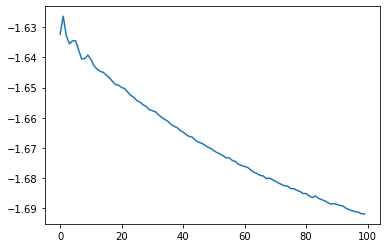

In [ ]:
plt.plot(l.losses)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()